# Disk galaxy with globular clusters

Generate a galaxy (exponential profile, r_eff=0.3", 50deg inclination), 
with integrated magnitude K_AB=24. Put a few point sources (globular 
cluster progenitors) around it with magnitudes in the range K_AB=26-28mag.
Set DIT=20sec and NDIT=6 (might need to increase this to see anything). 
And take 4 exposures with the object shifted by ~1arcsec each time (e.g. 
in a square). Use a MAORY-like PSF.

The MAORY-like PSF PSF_MCAO_Ks_Strehl40.fits needs to be placed where SimCADO can find it, either in the SIM_DATA_DIR or specifying the full path. 

**This example needs the latest version of SimCADO**

Use `pip install simcado --upgrade`

In [2]:
import simcado
import matplotlib.pyplot as plt
import numpy as np
from IPython.utils import io
print(simcado.__data_dir__)

/home/mverdugo/simcado_work/simcado/data


In [3]:
# Utility functions to calculate ellipticity from the inclination and vice versa

def inclination2ellipticity(inclination, q=0.2):
    """
    calculate galaxy ellipticity from the inclination (in degrees!)
    q is the true axis ratio with default q=0.2 as in Heidmann 1972
    """
    i = np.deg2rad(inclination)
    btoa = np.sqrt((1 - q**2) * np.cos(i)**2 + q**2)
    ell = 1 - btoa
    return ell

def ellipticity2inclination(ellipticity, q=0.2):
    """
    calculate galaxy inclination (in degrees) from the ellipticity measured on images
    q is the true axis ratio with default q=0.2 as in Heidmann 1972
    """
    btoa = 1 - ellipticity
    i =  np.arccos(np.sqrt( (btoa**2 - q**2)/(1 - q**2) ))
    inclination = np.rad2deg(i)
    return inclination

## Defining source parameters

In [4]:
# Galaxy parameters

magAB = 22 
magVega = magAB - 1.85
Reff = 0.3               # arcsec
n = 1                    # sersic index for a disk galaxy
inclination = 50         # deg
ellipticity = inclination2ellipticity(inclination)

gal_src = simcado.source.elliptical(Reff, 0.004, magnitude=magVega, n=1, 
                                    filter_name='TC_filter_Ks.dat', spectrum="spiral", 
                                    ellipticity=ellipticity)

# generate the 10 point sources with magnitudes between 26 and 28 
# and positions defined by a gaussian profile centered on the galaxy with FHWM=Reff

magnitudes = np.random.uniform(low=26, high=28, size=10) - 1.85
x_pos = np.random.normal(scale=Reff, size=10)
y_pos = np.random.normal(scale=Reff, size=10)

point_src = simcado.source.stars(mags=magnitudes, x=x_pos, y=y_pos, 
                                 spec_types="A0V", filter_name='TC_filter_Ks.dat')

# combining the two sources
combined_src = gal_src + point_src

In [5]:
# Starting with a DIT of 20s and doing 6 NDIT
t_exp = 20
NDIT = 6

#First DIT
hdu = simcado.run(combined_src, OBS_DIT=t_exp, detector_layout="small", 
                  FPA_LINEARITY_CURVE=None, filter_name='TC_filter_Ks.dat',
                  SCOPE_PSF_FILE="PSF_MCAO_Ks_Strehl40.fits",
                  SIM_VERBOSE="no", SIM_SIM_MESSAGE_LEVEL=0)

image = hdu[0].data
with io.capture_output() as captured: # to suppress excesive stdout text
    for n in range(NDIT-1):
        hdu = simcado.run(combined_src, OBS_DIT=t_exp, detector_layout="small",
                          FPA_LINEARITY_CURVE=None, filter_name='TC_filter_Ks.dat',
                          SCOPE_PSF_FILE="PSF_MCAO_Ks_Strehl40.fits")
    
        image  = image + hdu[0].data # coadding the images
        
print()
print("Total ExpTime:", NDIT*t_exp, "s")

Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast

Total ExpTime: 120 s


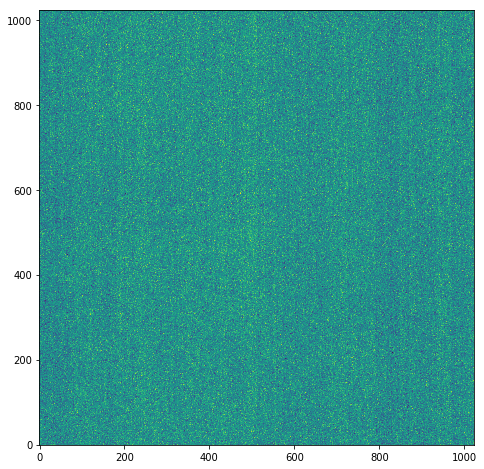

In [7]:
#showing the image
plt.figure(figsize=(8,8))
plt.imshow(image, origin="lower")


We don't see much so let's increase the exposure time

background per DIT is about 900 counts, we can safely increase the DIT by factor 20 
Texp = 8000s ~ 2h

In [6]:
t_exp = 400
NDIT = 20

hdu = simcado.run(combined_src, OBS_DIT=t_exp, detector_layout="small", 
                  FPA_LINEARITY_CURVE=None, filter_name='TC_filter_Ks.dat',
                  SCOPE_PSF_FILE="PSF_MCAO_Ks_Strehl40.fits")

image = hdu[0].data
with io.capture_output() as captured: # to suppress excesive stdout text
    for n in range(NDIT-1):
        hdu = simcado.run(combined_src, OBS_DIT=t_exp, detector_layout="small",
                          FPA_LINEARITY_CURVE=None, filter_name='TC_filter_Ks.dat',
                          SCOPE_PSF_FILE="PSF_MCAO_Ks_Strehl40.fits")
        
        image  = image + hdu[0].data # coadding the images

print()
print("Total ExpTime:", NDIT*t_exp, "s")

Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast

Total ExpTime: 8000 s


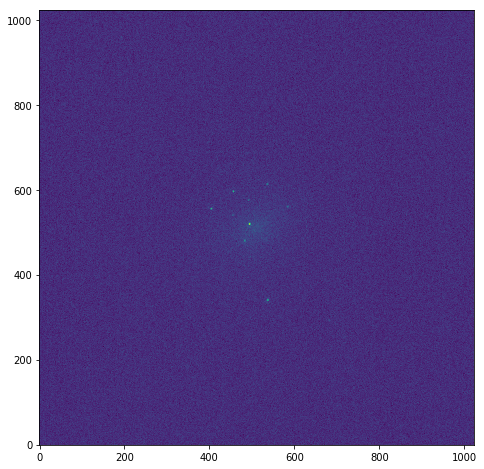

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(image, origin="lower") 

It is much faster to simulate using the total exposure time and suppress the linearity curve.

In [8]:
t_exp = 400
NDIT = 20
t_exp = t_exp*NDIT

hdu = simcado.run(combined_src, OBS_DIT=t_exp, detector_layout="small", 
                  FPA_LINEARITY_CURVE=None, filter_name='TC_filter_Ks.dat',
                  SCOPE_PSF_FILE="PSF_MCAO_Ks_Strehl40.fits")

image = hdu[0].data

Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast


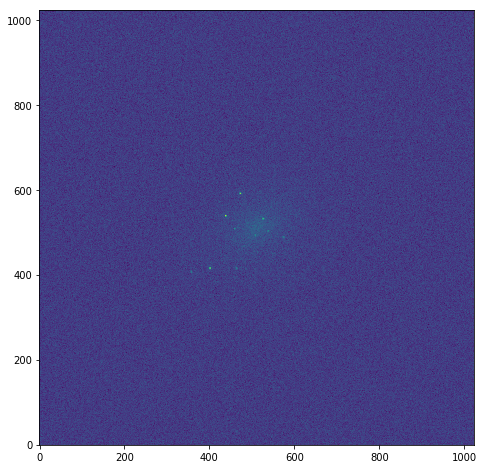

In [11]:
# plotting the results 

plt.figure(figsize=(8,8))
plt.imshow(image, origin="lower") 

In [9]:
# Saving the file
hdu.writeto("globclustersKs_center.fits", overwrite=True)

## Doing 4 dithers in a square pattern

In [10]:
t_exp = 400
NDIT = 20
t_exp = t_exp*NDIT

x_shifts = np.array([1,  1, -1, -1])
y_shifts = np.array([1, -1,  1, -1])

n=1
for xs,ys in zip(x_shifts, y_shifts):
    gal_src = simcado.source.elliptical(Reff, 0.004, magnitude=magVega, n=1, 
                                        x_offset= xs, y_offset=ys, 
                                        filter_name='TC_filter_Ks.dat', spectrum="spiral", 
                                        ellipticity=ellipticity)
    point_src = simcado.source.stars(mags=magnitudes, x=x_pos+xs, y=y_pos+ys, 
                                     filter_name='TC_filter_Ks.dat', spectype="A0V")

    combined_src = gal_src + point_src
    hdu = simcado.run(combined_src, OBS_DIT=t_exp, detector_layout="small", 
                  FPA_LINEARITY_CURVE=None, filter_name='TC_filter_Ks.dat',
                  SCOPE_PSF_FILE="PSF_MCAO_Ks_Strehl40.fits")
    filename = "globclustersKs_" + "dither" + str(n) + ".fits"
    n = n+1
    hdu.writeto(filename, overwrite=True)

Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- --

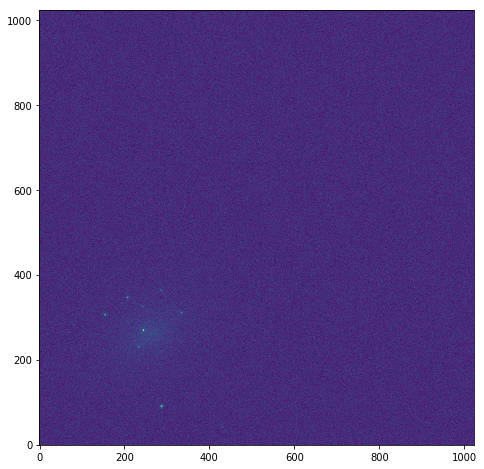

In [11]:
# plotting the last simulation
plt.figure(figsize=(8,8))
plt.imshow(hdu[0].data, origin="lower") 